In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
len(words)

32033

In [4]:
# build vocab of characters & integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
n_embd = 20
n_hidden = 200

batch_size = 32
max_steps = 200000

---

In [7]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [8]:
lri = []
lossi = []

In [9]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.6236
  10000/ 200000: 2.3586
  20000/ 200000: 3.3906
  30000/ 200000: 2.2856
  40000/ 200000: 2.3958
  50000/ 200000: 2.6770
  60000/ 200000: 2.7533
  70000/ 200000: 2.5031
  80000/ 200000: 2.0340
  90000/ 200000: 2.1700
 100000/ 200000: 1.8479
 110000/ 200000: 2.1497
 120000/ 200000: 1.9937
 130000/ 200000: 2.3109
 140000/ 200000: 2.2523
 150000/ 200000: 2.0581
 160000/ 200000: 2.2567
 170000/ 200000: 2.3063
 180000/ 200000: 1.7550
 190000/ 200000: 1.8847


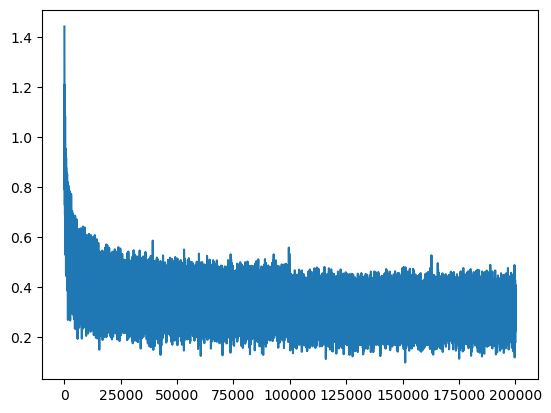

In [10]:
plt.plot(lossi)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0683655738830566
val 2.149495840072632


In [12]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chriah.
amelle.
khi.
mili.
thiyah.
cassie.
mahnen.
deliah.
jareei.
ner.
kia.
chaiiv.
kaleigh.
ham.
por.
desian.
shon.
wai.
adii.
wazell.


### Here we get slightly better val loss than in last notebook
    - Coz, W2 squashed by a factor of 0.01

# Problem 1: Analyzing BIG initial loss

## You could get a feel that these parameters are POORLY initialized
    - Coz, the loss abruptly starts from 27, and immediately comes around 1 or 2.

1. In neural networks, we should usually have idea of what **LOSS** to expect when starting training.
### Initially, we want to start where all our outcomes are equally likely
    - i.e., all 27 characters are equally likely
    - Means, 1/27 would be the approx value of logits
    - Logits coming out initially:
        - Need not be all low, they should initially be approx **equal**
            - It'll make the loss in below ballpark

In [13]:
# Therefore, the initial loss must be somewhere around
-(torch.tensor(1/27.)).log()

tensor(3.2958)

### Let's try to look into initial logits from out training code

In [14]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [15]:
lri = []
lossi = []

In [16]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 27.6236


In [17]:
logits[0]

tensor([  1.9399, -15.0631,  -4.6819,   7.2973,   5.4393, -28.7860,   3.2927,
         -9.0707,  -4.3792,  -6.7343,   4.3704,  15.6032,  -4.8591,  18.9556,
         -1.1279,   8.9634,  12.0877,   4.5551, -10.7433,   7.4244,   4.8697,
        -11.6449,   4.1232,   0.5606,   6.0747,  12.0631,  -5.7886],
       grad_fn=<SelectBackward0>)

### See the logits are taking extreme values on both sides,
    - Which are gives network fake confidence in wrong predictions

## Therefore, very very high loss

### We need logits much much closer to '0'
    - logits = h @ W2 + b2
    - we have b2 & W2 randomly initialized
        - Coz, we want nearly 0, we don't want to be adding any bias terms
            - make b2 ---> 0
    - Also to get logits close to 0, we want W2 very very small

In [18]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [19]:
lri = []
lossi = []

In [20]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3006


#### -------------->> We can see in very first iteration, loss is very low now (as compared to 32) <<--------------

In [21]:
logits[0]

tensor([ 0.0223, -0.1616, -0.0419,  0.0881,  0.0624, -0.2927,  0.0251, -0.0794,
        -0.0459, -0.0611,  0.0518,  0.1440, -0.0472,  0.1987, -0.0023,  0.1019,
         0.1311,  0.0285, -0.1018,  0.0611,  0.0551, -0.1174,  0.0407,  0.0174,
         0.0552,  0.1073, -0.0653], grad_fn=<SelectBackward0>)

In [22]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [23]:
# Training completely

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3006
  10000/ 200000: 2.0741
  20000/ 200000: 2.8459
  30000/ 200000: 2.3756
  40000/ 200000: 2.3108
  50000/ 200000: 2.6182
  60000/ 200000: 2.8379
  70000/ 200000: 2.4886
  80000/ 200000: 2.1391
  90000/ 200000: 2.2671
 100000/ 200000: 1.7832
 110000/ 200000: 2.1521
 120000/ 200000: 1.9627
 130000/ 200000: 2.2624
 140000/ 200000: 2.2098
 150000/ 200000: 1.9764
 160000/ 200000: 2.3625
 170000/ 200000: 2.1684
 180000/ 200000: 1.8394
 190000/ 200000: 1.8926


In [24]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0474190711975098
val 2.1241793632507324


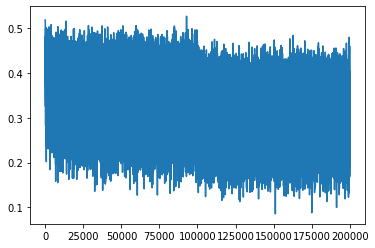

In [25]:
plt.plot(lossi)

# Loss no longer has hockey shape
# Coz, we took away big squashing iteration from training

#### Val Loss - a bit lower now with same amount of training

# Problem 2: Issue with 'h'

In [26]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [27]:
# Training completely

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3006


#### Now 'logits' are okay, let look at 'h'

In [28]:
h # see there are many 1s and -1s

tensor([[-0.9996,  1.0000,  1.0000,  ..., -1.0000,  1.0000, -0.8630],
        [ 0.9998,  1.0000, -1.0000,  ...,  1.0000,  1.0000, -0.9956],
        [-0.4379,  0.5210,  0.9982,  ..., -1.0000, -1.0000, -0.8215],
        ...,
        [ 1.0000,  1.0000,  0.9265,  ...,  0.6167, -0.9602,  1.0000],
        [ 1.0000,  1.0000,  0.9296,  ...,  1.0000,  1.0000, -0.9102],
        [-0.9554,  0.9997, -1.0000,  ...,  1.0000,  0.9442, -0.8189]],
       grad_fn=<TanhBackward0>)

In [29]:
h.shape, h.view(-1).shape

(torch.Size([32, 200]), torch.Size([6400]))

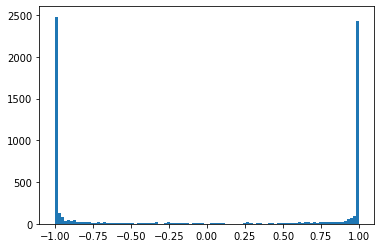

In [30]:
plt.hist(h.view(-1).tolist(), 100)
plt.show()

#### See that most of the activations 'h' - are 1 or -1.

#### To further investigate, lets look at 'hpreact'

In [31]:
hpreact

tensor([[ -4.3160,  15.5984,   8.7359,  ...,  -7.7758,  16.9325,  -1.3048],
        [  4.7077,   8.7443,  -5.8499,  ...,  14.2167,   8.7446,  -3.0594],
        [ -0.4696,   0.5778,   3.5113,  ...,  -8.4818, -17.3020,  -1.1614],
        ...,
        [  9.7110,  13.2891,   1.6333,  ...,   0.7197,  -1.9481,  14.6777],
        [  5.6733,  13.6989,   1.6552,  ...,  12.3228,   7.3850,  -1.5288],
        [ -1.8900,   4.4814,  -8.3921,  ...,  10.2091,   1.7756,  -1.1535]],
       grad_fn=<AddBackward0>)

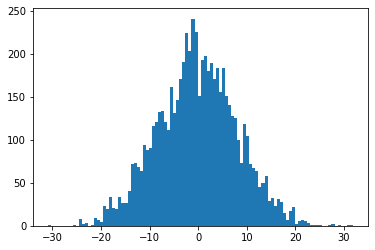

In [32]:
plt.hist(hpreact.view(-1).tolist(), 100)
plt.show()

### Lots of numbers are again taking extreme values
    - Gradient of tanh ---> (1 - t**2) * out.grad
        - when input to tanh becomes extreme in either directions
            - t becomes almost -1 or 1
                - Making the term (1 - t**2) almost 0
    - This property stops gradient (out.grad) from flowing backwards
    - Also, the slope of tanh curve towards extreme is tending to 0
    
    - Whereas, when t ~ 0
        - gradient passes through easily

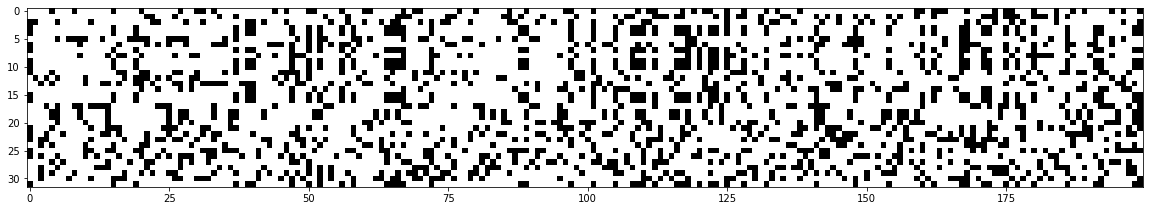

In [33]:
# visualizing the activations h

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# 32 examples in y-axis
# 200 neurons in x-axis

## We see that a lot of neurons activations are landing above 0.99 (shown in WHITE)

### Let's tweak initialization of W1 & b1 to handle this issue

In [34]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.15
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [35]:
# Training completely

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.2999


#### Now 'logits' are okay, let look at 'h'

In [36]:
h # see there are many 1s and -1s

tensor([[-0.5913,  0.9769,  0.8683,  ..., -0.8221,  0.9868, -0.2857],
        [ 0.5875,  0.8328, -0.6972,  ...,  0.9725,  0.8560, -0.5058],
        [-0.1024, -0.0279,  0.4948,  ..., -0.8536, -0.9896, -0.2658],
        ...,
        [ 0.8905,  0.9544,  0.2550,  ...,  0.1106, -0.3147,  0.9707],
        [ 0.6744,  0.9596,  0.2581,  ...,  0.9519,  0.7910, -0.3163],
        [-0.3057,  0.5062, -0.8463,  ...,  0.9112,  0.2286, -0.2647]],
       grad_fn=<TanhBackward0>)

In [37]:
h.shape, h.view(-1).shape

(torch.Size([32, 200]), torch.Size([6400]))

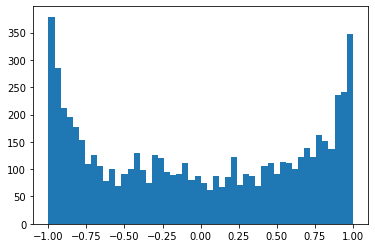

In [38]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

#### See that most of the activations 'h' - are 1 or -1.

#### To further investigate, lets look at 'hpreact'

In [39]:
hpreact

tensor([[-0.6797,  2.2252,  1.3261,  ..., -1.1632,  2.5063, -0.2939],
        [ 0.6739,  1.1971, -0.8617,  ...,  2.1356,  1.2781, -0.5571],
        [-0.1027, -0.0279,  0.5424,  ..., -1.2691, -2.6289, -0.2724],
        ...,
        [ 1.4244,  1.8788,  0.2607,  ...,  0.1111, -0.3258,  2.1035],
        [ 0.8187,  1.9403,  0.2640,  ...,  1.8516,  1.0742, -0.3275],
        [-0.3158,  0.5577, -1.2431,  ...,  1.5345,  0.2328, -0.2712]],
       grad_fn=<AddBackward0>)

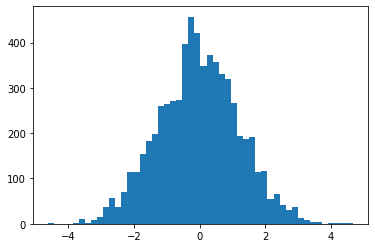

In [40]:
plt.hist(hpreact.view(-1).tolist(), 50)
plt.show()

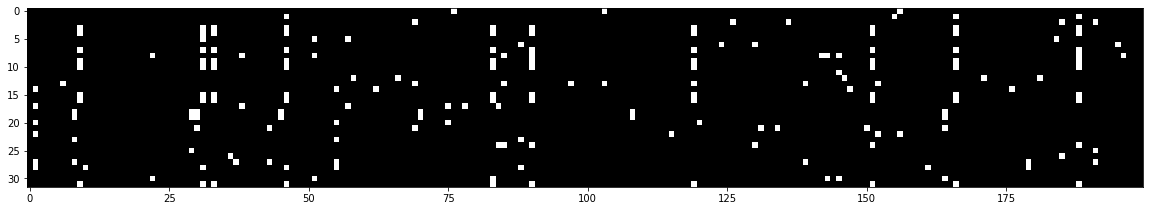

In [41]:
# visualizing the activations h

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# 32 examples in y-axis
# 200 neurons in x-axis

## Now we get most activations below 0.99 (shown in BLACK)

### ------------>> Complete the training with both improvements <<------------

In [42]:
# initializing parameters

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.15
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

18167

In [43]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2999
  10000/ 200000: 2.0512
  20000/ 200000: 2.7255
  30000/ 200000: 2.2408
  40000/ 200000: 2.1843
  50000/ 200000: 2.4287
  60000/ 200000: 2.5718
  70000/ 200000: 2.2844
  80000/ 200000: 1.9442
  90000/ 200000: 2.0770
 100000/ 200000: 1.7253
 110000/ 200000: 1.9746
 120000/ 200000: 1.9718
 130000/ 200000: 2.2139
 140000/ 200000: 2.1614
 150000/ 200000: 1.9444
 160000/ 200000: 2.2914
 170000/ 200000: 2.1319
 180000/ 200000: 1.6743
 190000/ 200000: 1.8167
